<a href="https://colab.research.google.com/github/Seyiul/ConvNet_Challenge_Colorization/blob/main/UNet_Colorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import os
import zipfile
import tqdm

file_name = "Multimedia_dataset.zip"
zip_path = os.path.join('/content/drive/MyDrive/Multimedia_dataset.zip')
!cp "{zip_path}" .
!unzip -q "{file_name}"
!rm "{file_name}"

test_set = "colorization_test_dataset.zip"
test_zip_path = os.path.join('/content/drive/MyDrive/colorization_test_dataset.zip')
!cp "{test_zip_path}" .
!unzip -q "{test_set}"
!rm "{test_set}"

replace train/image_000000.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
replace hint/0.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [3]:
# Download and import libraries
!pip install torch torchvision matplotlib numpy scikit-image pillow==4.1.1

In [4]:
import os
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb

import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_colab = None

In [5]:
# For plotting
import numpy as np
import matplotlib.pyplot as plt
# For conversion
from skimage.color import lab2rgb, rgb2lab, rgb2gray
from skimage import io
# For everything
import torch
import torch.nn as nn
import torch.nn.functional as F
# For our model
import torchvision.models as models
from torchvision import datasets, transforms
# For utilities
import os, shutil, time


# Check if GPU is available
use_gpu = torch.cuda.is_available()
print('use gpu:',use_gpu)

use gpu: True


In [6]:
import torch
from torch.autograd import Variable
from torchvision import transforms

import cv2
import random
import numpy as np

class ColorHintTransform(object):
  def __init__(self, size=256, mode="training"):
    super(ColorHintTransform, self).__init__()
    self.size = size
    self.mode = mode
    self.transform = transforms.Compose([transforms.ToTensor()])

  def bgr_to_lab(self, img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, ab = lab[:, :, 0], lab[:, :, 1:]
    return l, ab

  def hint_mask(self, bgr, threshold=[0.95, 0.97, 0.99]):
    h, w, c = bgr.shape
    mask_threshold = random.choice(threshold)
    mask = np.random.random([h, w, 1]) > mask_threshold
    return mask

  def img_to_mask(self, mask_img):
    mask = mask_img[:, :, 0, np.newaxis] >= 255
    return mask

  def __call__(self, img, mask_img=None):
    threshold = [0.95, 0.97, 0.99]
    if (self.mode == "training") | (self.mode == "validation"):
      image = cv2.resize(img, (self.size, self.size))
      mask = self.hint_mask(image, threshold)

      hint_image = image * mask

      l, ab = self.bgr_to_lab(image)
      l_hint, ab_hint = self.bgr_to_lab(hint_image)

      return self.transform(l), self.transform(ab), self.transform(ab_hint)

    elif self.mode == "testing":
      image = cv2.resize(img, (self.size, self.size))
      hint_image = image * self.img_to_mask(mask_img)

      l, _ = self.bgr_to_lab(image)
      _, ab_hint = self.bgr_to_lab(hint_image)

      return self.transform(l), self.transform(ab_hint)

    else:
      return NotImplementedError

In [7]:
import torch
import torch.utils.data  as data
import os
import cv2
from google.colab.patches import cv2_imshow

class ColorHintDataset(data.Dataset):
  def __init__(self, root_path, size):
    super(ColorHintDataset, self).__init__()

    self.root_path = root_path
    self.size = size
    self.transforms = None
    self.examples = None
    self.hint = None
    self.mask = None

  def set_mode(self, mode):
    self.mode = mode
    self.transforms = ColorHintTransform(self.size, mode)
    if mode == "training":
      train_dir = os.path.join(self.root_path, "train")
      self.examples = [os.path.join(self.root_path, "train", dirs) for dirs in os.listdir(train_dir)]
    elif mode == "validation":
      val_dir = os.path.join(self.root_path, "validation")
      self.examples = [os.path.join(self.root_path, "validation", dirs) for dirs in os.listdir(val_dir)]
    elif mode == "testing":
      hint_dir = os.path.join(self.root_path, "hint")
      mask_dir = os.path.join(self.root_path, "mask")
      self.hint = [os.path.join(self.root_path, "hint", dirs) for dirs in os.listdir(hint_dir)]
      self.mask = [os.path.join(self.root_path, "mask", dirs) for dirs in os.listdir(mask_dir)]
    else:
      raise NotImplementedError

  def __len__(self):
    if self.mode != "testing":
      return len(self.examples)
    else:
      return len(self.hint)

  def __getitem__(self, idx):
    if self.mode == "testing":
      hint_file_name = self.hint[idx]
      mask_file_name = self.mask[idx]
      hint_img = cv2.imread(hint_file_name)
      mask_img = cv2.imread(mask_file_name)

      input_l, input_hint = self.transforms(hint_img, mask_img)
      sample = {"l": input_l, "hint": input_hint,
                "file_name": "image_%06d.png" % int(os.path.basename(hint_file_name).split('.')[0])}
    else:
      file_name = self.examples[idx]
      img = cv2.imread(file_name)
      l, ab, hint = self.transforms(img)
      sample = {"l": l, "ab": ab, "hint": hint}

    return sample

In [8]:
import torch
import torch.utils.data  as data
import os
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms
import tqdm
from PIL import Image
import numpy as np

def tensor2im(input_image, imtype=np.uint8):
  if isinstance(input_image, torch.Tensor):
      image_tensor = input_image.data
  else:
      return input_image
  image_numpy = image_tensor[0].cpu().float().numpy()
  if image_numpy.shape[0] == 1:
      image_numpy = np.tile(image_numpy, (3, 1, 1))
  image_numpy = np.clip((np.transpose(image_numpy, (1, 2, 0)) ),0, 1) * 255.0
  return image_numpy.astype(imtype)

# Change to your data root directory
root_path = "/content/"
# Depend on runtime setting
use_cuda = True

train_dataset = ColorHintDataset(root_path, 128)
train_dataset.set_mode("training")
train_dataloader = data.DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = ColorHintDataset(root_path, 128)
val_dataset.set_mode("validation")
val_dataloader = data.DataLoader(val_dataset, batch_size=16, shuffle=True)

test_dataset = ColorHintDataset(root_path, 128)
test_dataset.set_mode("testing")
test_dataloader = data.DataLoader(test_dataset, batch_size=1, shuffle=False)


In [9]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
            layers = []
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                 kernel_size=kernel_size, stride=stride, padding=padding,
                                 bias=bias)]
            layers += [nn.BatchNorm2d(num_features=out_channels)]

            cbr = nn.Sequential(*layers)

            return cbr

        # Contracting path
        self.enc1_1 = CBR2d(in_channels=3, out_channels=32)
        self.enc1_2 = CBR2d(in_channels=32, out_channels=32)

        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.enc2_1 = CBR2d(in_channels=32, out_channels=64)
        self.enc2_2 = CBR2d(in_channels=64, out_channels=64)

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.enc3_1 = CBR2d(in_channels=64, out_channels=128)


        # Expansive path

        self.dec3_1 = CBR2d(in_channels=128, out_channels=64)

        self.unpool2 = nn.ConvTranspose2d(in_channels=64, out_channels=64,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec2_2 = CBR2d(in_channels=2 * 64, out_channels=64)
        self.dec2_1 = CBR2d(in_channels=64, out_channels=32)

        self.unpool1 = nn.ConvTranspose2d(in_channels=32, out_channels=32,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec1_2 = CBR2d(in_channels=2 * 32, out_channels=32)
        self.dec1_1 = CBR2d(in_channels=32, out_channels=32)

        self.fc = nn.Conv2d(in_channels=32, out_channels=2, kernel_size=1, stride=1, padding=0, bias=True)

    def forward(self, x):
        enc1_1 = F.relu(self.enc1_1(x))
        enc1_2 = F.relu(self.enc1_2(enc1_1))
        pool1 = F.relu(self.pool1(enc1_2))

        enc2_1 = F.relu(self.enc2_1(pool1))
        enc2_2 = F.relu(self.enc2_2(enc2_1))
        pool2 = F.relu(self.pool2(enc2_2))

        enc3_1 = F.relu(self.enc3_1(pool2))
       
        dec3_1 = F.relu(self.dec3_1(enc3_1))

        unpool2 = F.relu(self.unpool2(dec3_1))
        cat2 = torch.cat((unpool2, enc2_2), dim=1)
        dec2_2 = F.relu(self.dec2_2(cat2))
        dec2_1 = F.relu(self.dec2_1(dec2_2))

        unpool1 = F.relu(self.unpool1(dec2_1))
        cat1 = torch.cat((unpool1, enc1_2), dim=1)
        dec1_2 = F.relu(self.dec1_2(cat1))
        dec1_1 = F.relu(self.dec1_1(dec1_2))

        x = self.fc(dec1_1)

        return x

model = UNet()
criterion = nn.MSELoss() #Loss Function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.0) #Optimizer

In [10]:
class AverageMeter(object):
  '''A handy class from the PyTorch ImageNet tutorial''' 
  def __init__(self):
    self.reset()
  def reset(self):
    self.val, self.avg, self.sum, self.count = 0, 0, 0, 0
  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count


In [11]:
def to_rgb(grayscale_input, ab_input, save_path=None, save_name=None):
  '''Show/save rgb image from grayscale and ab channels
     Input save_path in the form {'grayscale': '/path/', 'colorized': '/path/'}'''
  plt.clf() # clear matplotlib 
  color_image = torch.cat((grayscale_input, ab_input), 0).numpy() # combine channels
  color_image = color_image.transpose((1, 2, 0))  # rescale for matplotlib
  color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
  color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128   
  color_image = lab2rgb(color_image.astype(np.float64))
  grayscale_input = grayscale_input.squeeze().numpy()
  if save_path is not None and save_name is not None: 
    plt.imsave(arr=grayscale_input, fname='{}{}'.format(save_path['grayscale'], save_name), cmap='gray')
    plt.imsave(arr=color_image, fname='{}{}'.format(save_path['colorized'], save_name))

In [12]:
def to_rgb_result(grayscale_input, ab_input, save_path=None, save_name=None):
  plt.clf() # clear matplotlib 
  color_image = torch.cat((grayscale_input, ab_input), 0).numpy() # combine channels
  color_image = color_image.transpose((1, 2, 0))  # rescale for matplotlib
  color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
  color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128   
  color_image = lab2rgb(color_image.astype(np.float64))
  grayscale_input = grayscale_input.squeeze().numpy()
  if save_path is not None and save_name is not None: 
    plt.imsave(arr=color_image, fname='{}{}'.format(save_path['result'],save_name))

In [13]:
def validate(val_loader, model, criterion, save_images, epoch):
  model.eval()

  # Prepare value counters and timers
  batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

  end = time.time()
  already_saved_images = False
 # for i, (input_gray, input_ab, target) in enumerate(val_loader):
    

    # Use GPU
    #if use_gpu: input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()
  for i, data in enumerate(val_dataloader):
    data_time.update(time.time() - end)
  
    if use_cuda:
      input_gray = data["l"].to('cuda')
      input_ab = data["ab"].to('cuda')
      hint = data["hint"].to('cuda')

    
    gt_image = torch.cat((input_gray, input_ab), dim=1)
    hint_image = torch.cat((input_gray, hint), dim=1)

    # Run model and record loss
    output_ab = model(hint_image) # throw away class predictions
    loss = criterion(output_ab, input_ab)
    losses.update(loss.item(), hint_image.size(0))  #???????????

    # Save images to file
    if save_images and not already_saved_images:
      already_saved_images = True
      for j in range(min(len(output_ab), 30)): # save at most 5 images
        save_path = {'grayscale': 'outputs/gray/', 'colorized': 'outputs/color/'}
        save_name = 'img-{}-epoch-{}.jpg'.format(i * val_loader.batch_size + j, epoch)
        to_rgb(input_gray[j].cpu(), ab_input=output_ab[j].detach().cpu(), save_path=save_path, save_name=save_name)

    # Record time to do forward passes and save images
    batch_time.update(time.time() - end)
    end = time.time()

    # Print model accuracy -- in the code below, val refers to both value and validation
    if i % 25 == 0:
      print('Validate: [{0}/{1}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
             i, len(val_loader), batch_time=batch_time, loss=losses))

  print('Finished validation.')
  return losses.avg

In [14]:
def train(train_loader, model, criterion, optimizer, epoch):
  print('Starting training epoch {}'.format(epoch))
  model.train()
  
  # Prepare value counters and timers
  batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

  end = time.time()
  #for i, (input_gray, input_ab, target) in enumerate(train_loader):
  for i, data in enumerate(train_dataloader):
  
    if use_cuda:
      input_gray = data["l"].to('cuda')
      input_ab = data["ab"].to('cuda')
      hint = data["hint"].to('cuda')
  
    gt_image = torch.cat((input_gray, input_ab), dim=1)
    hint_image = torch.cat((input_gray, hint), dim=1)
    
    # Use GPU if available
    #if use_gpu: input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()

    # Record time to load data (above)
    data_time.update(time.time() - end)

    # Run forward pass
    output_ab = model(hint_image) 
    loss = criterion(output_ab, input_ab) 
    losses.update(loss.item(), hint_image.size(0)) #???????????

    # Compute gradient and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Record time to do forward and backward passes
    batch_time.update(time.time() - end)
    end = time.time()

    # Print model accuracy -- in the code below, val refers to value, not validation
    if i % 25 == 0:
      print('Epoch: [{0}][{1}/{2}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
              epoch, i, len(train_loader), batch_time=batch_time,
             data_time=data_time, loss=losses)) 

  print('Finished training epoch {}'.format(epoch))

In [15]:
# Move model and loss function to GPU
if use_gpu: 
  criterion = criterion.cuda()
  model = model.cuda()

In [16]:
# Make folders and set parameters
os.makedirs('outputs/color', exist_ok=True)
os.makedirs('outputs/gray', exist_ok=True)
os.makedirs('checkpoints1', exist_ok=True)
save_images = True
best_losses = 1e10
epochs = 100

save_path = './ColorizationNetwork'
os.makedirs(save_path,exist_ok=True)
output_path = os.path.join(save_path, 'basic_model.tar')


In [17]:
# Train model
for epoch in range(epochs):
  # Train for one epoch, then validate
  train(train_dataloader, model, criterion, optimizer, epoch)
  with torch.no_grad():
    losses = validate(val_dataloader, model, criterion, save_images, epoch)
  # Save checkpoint and replace old best model if current model is better
  if losses < best_losses:
    best_losses = losses
    torch.save(model.state_dict(), 'checkpoints1/model-epoch-{}-losses-{:.6f}.pth'.format(epoch+1,losses))


Starting training epoch 0
Epoch: [0][0/282]	Time 0.483 (0.483)	Data 0.284 (0.284)	Loss 0.2050 (0.2050)	
Epoch: [0][25/282]	Time 0.067 (0.087)	Data 0.043 (0.054)	Loss 0.0064 (0.0394)	
Epoch: [0][50/282]	Time 0.071 (0.077)	Data 0.047 (0.049)	Loss 0.0035 (0.0224)	
Epoch: [0][75/282]	Time 0.067 (0.075)	Data 0.043 (0.047)	Loss 0.0049 (0.0164)	
Epoch: [0][100/282]	Time 0.069 (0.073)	Data 0.044 (0.046)	Loss 0.0040 (0.0134)	
Epoch: [0][125/282]	Time 0.068 (0.072)	Data 0.043 (0.046)	Loss 0.0026 (0.0115)	
Epoch: [0][150/282]	Time 0.071 (0.072)	Data 0.046 (0.046)	Loss 0.0040 (0.0103)	
Epoch: [0][175/282]	Time 0.069 (0.071)	Data 0.044 (0.045)	Loss 0.0018 (0.0092)	
Epoch: [0][200/282]	Time 0.066 (0.071)	Data 0.042 (0.045)	Loss 0.0026 (0.0085)	
Epoch: [0][225/282]	Time 0.066 (0.071)	Data 0.042 (0.045)	Loss 0.0027 (0.0079)	
Epoch: [0][250/282]	Time 0.070 (0.071)	Data 0.045 (0.045)	Loss 0.0044 (0.0074)	
Epoch: [0][275/282]	Time 0.068 (0.071)	Data 0.044 (0.045)	Loss 0.0021 (0.0069)	
Finished training e

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 22 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 47 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 3 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 27 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color d

Validate: [0/32]	Time 0.253 (0.253)	Loss 0.0152 (0.0152)	
Validate: [25/32]	Time 0.061 (0.068)	Loss 0.0141 (0.0139)	
Finished validation.
Starting training epoch 1
Epoch: [1][0/282]	Time 0.070 (0.070)	Data 0.045 (0.045)	Loss 0.0027 (0.0027)	
Epoch: [1][25/282]	Time 0.067 (0.068)	Data 0.042 (0.043)	Loss 0.0018 (0.0025)	
Epoch: [1][50/282]	Time 0.066 (0.068)	Data 0.042 (0.044)	Loss 0.0028 (0.0026)	
Epoch: [1][75/282]	Time 0.068 (0.068)	Data 0.044 (0.043)	Loss 0.0015 (0.0025)	
Epoch: [1][100/282]	Time 0.070 (0.068)	Data 0.045 (0.043)	Loss 0.0019 (0.0024)	
Epoch: [1][125/282]	Time 0.070 (0.069)	Data 0.045 (0.044)	Loss 0.0021 (0.0024)	
Epoch: [1][150/282]	Time 0.071 (0.069)	Data 0.047 (0.043)	Loss 0.0021 (0.0024)	
Epoch: [1][175/282]	Time 0.069 (0.069)	Data 0.044 (0.044)	Loss 0.0015 (0.0023)	
Epoch: [1][200/282]	Time 0.068 (0.069)	Data 0.043 (0.043)	Loss 0.0025 (0.0023)	
Epoch: [1][225/282]	Time 0.068 (0.069)	Data 0.044 (0.043)	Loss 0.0017 (0.0023)	
Epoch: [1][250/282]	Time 0.066 (0.069)	Da

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 7 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Validate: [0/32]	Time 0.213 (0.213)	Loss 0.0012 (0.0012)	
Validate: [25/32]	Time 0.061 (0.067)	Loss 0.0012 (0.0013)	
Finished validation.
Starting training epoch 4
Epoch: [4][0/282]	Time 0.077 (0.077)	Data 0.052 (0.052)	Loss 0.0012 (0.0012)	
Epoch: [4][25/282]	Time 0.067 (0.069)	Data 0.042 (0.044)	Loss 0.0018 (0.0013)	
Epoch: [4][50/282]	Time 0.068 (0.069)	Data 0.043 (0.044)	Loss 0.0016 (0.0012)	
Epoch: [4][75/282]	Time 0.069 (0.069)	Data 0.044 (0.044)	Loss 0.0016 (0.0012)	
Epoch: [4][100/282]	Time 0.070 (0.069)	Data 0.042 (0.044)	Loss 0.0013 (0.0012)	
Epoch: [4][125/282]	Time 0.073 (0.069)	Data 0.048 (0.044)	Loss 0.0016 (0.0012)	
Epoch: [4][150/282]	Time 0.067 (0.069)	Data 0.043 (0.043)	Loss 0.0009 (0.0012)	
Epoch: [4][175/282]	Time 0.069 (0.069)	Data 0.044 (0.043)	Loss 0.0014 (0.0012)	
Epoch: [4][200/282]	Time 0.066 (0.068)	Data 0.041 (0.043)	Loss 0.0007 (0.0012)	
Epoch: [4][225/282]	Time 0.070 (0.068)	Data 0.045 (0.043)	Loss 0.0009 (0.0012)	
Epoch: [4][250/282]	Time 0.068 (0.068)	Da

<Figure size 432x288 with 0 Axes>

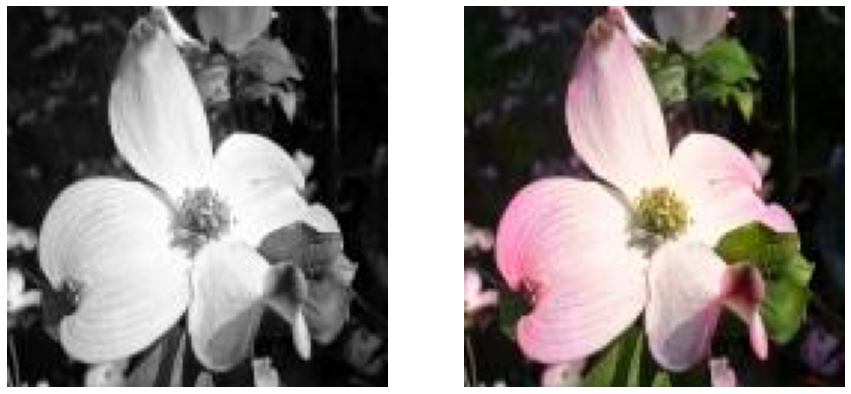

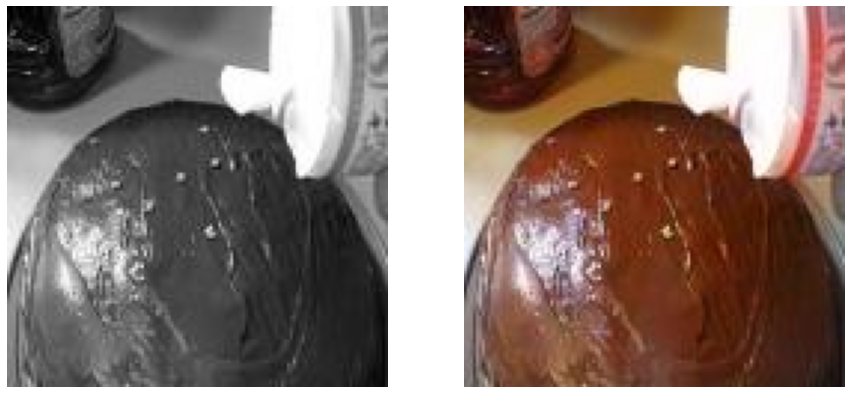

end


In [18]:

# Show images 
import matplotlib.image as mpimg
image_pairs = [('outputs/color/img-13-epoch-49.jpg', 'outputs/gray/img-13-epoch-49.jpg'),
               ('outputs/color/img-12-epoch-49.jpg', 'outputs/gray/img-12-epoch-49.jpg')]
for c, g in image_pairs:
  color = mpimg.imread(c)
  gray  = mpimg.imread(g)
  f, axarr = plt.subplots(1, 2)
  f.set_size_inches(15, 15)
  axarr[0].imshow(gray, cmap='gray')
  axarr[1].imshow(color)
  axarr[0].axis('off'), axarr[1].axis('off')
  plt.show()


print('end')


In [19]:
import torch
import os

os.makedirs('result', exist_ok=True)

#print(state_dict['model_weight'].keys())

def test_1epoch(net,dataloader):

  net.eval() #testing mode // eval

  for i, data in enumerate(dataloader):
    if use_cuda:
      l = data["l"].to('cuda')
      hint = data["hint"].to('cuda')
      file_name = data['file_name']
    
    hint_image = torch.cat((l, hint), dim=1)
    # hint_image = hint_image .float().cuda()
    output_ab = net(hint_image)
  


    for j in range(len(output_ab)): # save at most 5 images
      save_path = {'result': 'result/'}
      # save_name = 'image_%06d.png' %int(j)
      to_rgb_result(l[j].cpu(), ab_input=output_ab[j].detach().cpu(), save_path=save_path, save_name=file_name[j])


test_1epoch(model,test_dataloader)


<Figure size 432x288 with 0 Axes>

In [ ]:
!zip -r /content/result.zip /content/result
from google.colab import files
files.download("/content/result.zip")